In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xml.etree.ElementTree as ET
import base64
import struct
import sys

In [19]:
def extract_field(content, fieldname, is_position=False):
    """Extract field data from XML content"""
    try:
        tree = ET.ElementTree(ET.fromstring(content))
        root = tree.getroot()
        
        # Find DataArray with the specified name
        data_array = None
        for elem in root.iter('DataArray'):
            if elem.get('Name') == fieldname:
                data_array = elem
                break
                
        if data_array is None:
            raise ValueError(f"Field {fieldname} not found")
            
        # Get data format information
        format_str = data_array.get('format', 'ascii')
        n_components = int(data_array.get('NumberOfComponents', '1'))
        dtype_str = data_array.get('type', 'Float64')
        
        print(f"\nProcessing {fieldname}:")
        print(f"Format: {format_str}")
        print(f"Components: {n_components}")
        print(f"Type: {dtype_str}")
        
        if format_str == 'ascii':
            # ASCII format
            data = np.array([float(x) for x in data_array.text.split()])
        else:
            # Binary format - VTK format includes header
            try:
                binary_str = data_array.text.strip()
                binary_data = base64.b64decode(binary_str)
                
                # First 4 bytes contain the length of the data
                header_size = 4
                header = np.frombuffer(binary_data[:header_size], dtype=np.int32)[0]
                
                # The rest is the actual data
                data_bytes = binary_data[header_size:]
                if dtype_str == 'Float64':
                    dtype = np.dtype(np.float64)
                elif dtype_str == 'Float32':
                    dtype = np.dtype(np.float32)
                else:
                    raise ValueError(f"Unsupported data type: {dtype_str}")
                    
                if sys.byteorder == 'big':
                    dtype = dtype.newbyteorder('>')
                else:
                    dtype = dtype.newbyteorder('<')
                
                print(f"Header size: {header}")
                print(f"Data size: {len(data_bytes)} bytes")
                print(f"Expected elements: {header // dtype.itemsize}")
                
                data = np.frombuffer(data_bytes, dtype=dtype)
                print(f"Actual elements: {len(data)}")
                
            except Exception as e:
                print(f"Error decoding binary data: {str(e)}")
                print(f"Binary string length: {len(binary_str)}")
                print(f"Decoded data length: {len(binary_data)}")
                return None
            
        # Reshape if needed
        if is_position and n_components > 1:
            data = data.reshape(-1, n_components)
        elif n_components > 1:
            data = data.reshape(-1, n_components)
        
        print(f"Final data shape: {data.shape}")
        return data
        
    except Exception as e:
        print(f"Error extracting field {fieldname}: {e}")
        return None


Trying to read file: /home/faranak/CASL/workspace/simulations_output/poisson-nodes-mls-nick/vtu/nodes_5_1x1.0.vtu/0000.vtu

Processing Position:
Format: binary
Components: 3
Type: Float64
Header size: 22824
Data size: 22824 bytes
Expected elements: 2853
Actual elements: 2853
Final data shape: (951, 3)

Processing phi:
Format: binary
Components: 1
Type: Float64
Header size: 7608
Data size: 7608 bytes
Expected elements: 951
Actual elements: 951
Final data shape: (951,)

Processing sol:
Format: binary
Components: 1
Type: Float64
Header size: 7608
Data size: 7608 bytes
Expected elements: 951
Actual elements: 951
Final data shape: (951,)

Trying to read file: /home/faranak/CASL/workspace/simulations_output/poisson-nodes-mls-nick/vtu/nodes_5_1x1.0.vtu/0001.vtu

Processing Position:
Format: binary
Components: 3
Type: Float64
Header size: 24360
Data size: 24360 bytes
Expected elements: 3045
Actual elements: 3045
Final data shape: (1015, 3)

Processing phi:
Format: binary
Components: 1
Type: F

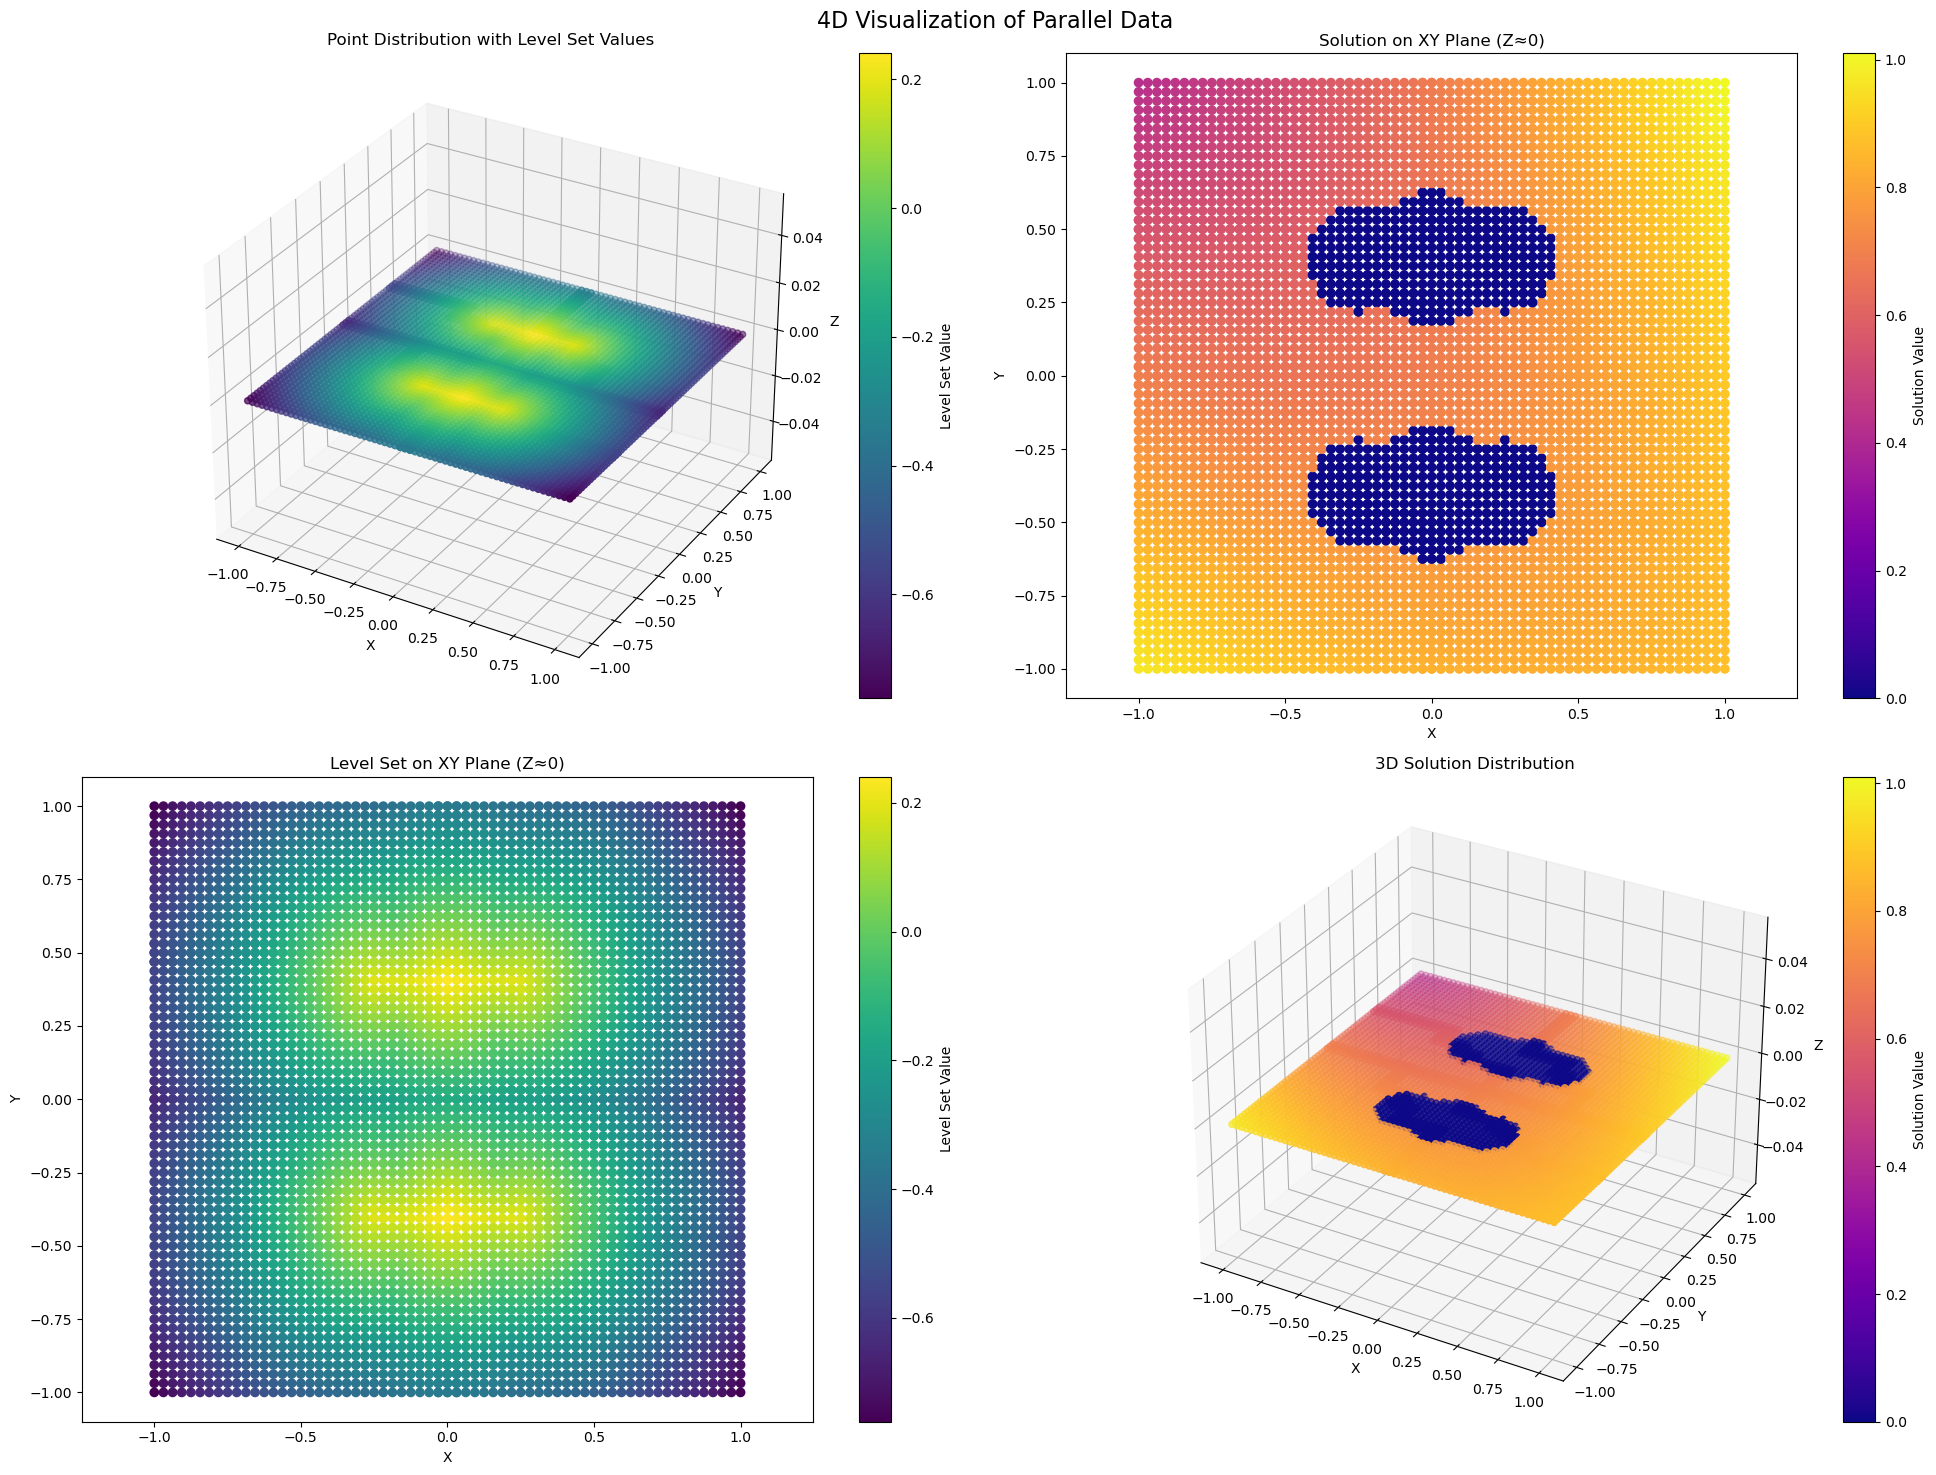

In [21]:
def visualize_4d_parallel_data(points, phi, sol, title="4D Visualization of Parallel Data"):
    """
    Create comprehensive visualization for parallel-processed 3D data
    
    Parameters:
    -----------
    points : array (N,3)
        3D coordinates
    phi : array (N,)
        Level set values
    sol : array (N,)
        Solution values
    """
    # Create figure with 2x2 layout
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Show points colored by processors
    ax1 = fig.add_subplot(221, projection='3d')
    scatter = ax1.scatter(points[:,0], points[:,1], points[:,2], 
                         c=phi, cmap='viridis')
    plt.colorbar(scatter, ax=ax1, label='Level Set Value')
    ax1.set_title('Point Distribution with Level Set Values')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # 2. Solution on XY plane (Z=0 slice)
    ax2 = fig.add_subplot(222)
    z_slice_mask = np.abs(points[:,2]) < 0.01
    scatter = ax2.scatter(points[z_slice_mask,0], 
                         points[z_slice_mask,1],
                         c=sol[z_slice_mask],
                         cmap='plasma')
    plt.colorbar(scatter, ax=ax2, label='Solution Value')
    ax2.set_title('Solution on XY Plane (Z≈0)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.axis('equal')
    
    # 3. Level set on XY plane
    ax3 = fig.add_subplot(223)
    scatter = ax3.scatter(points[z_slice_mask,0], 
                         points[z_slice_mask,1],
                         c=phi[z_slice_mask],
                         cmap='viridis')
    plt.colorbar(scatter, ax=ax3, label='Level Set Value')
    ax3.set_title('Level Set on XY Plane (Z≈0)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.axis('equal')
    
    # 4. 3D view of solution
    ax4 = fig.add_subplot(224, projection='3d')
    scatter = ax4.scatter(points[:,0], points[:,1], points[:,2],
                         c=sol, cmap='plasma')
    plt.colorbar(scatter, ax=ax4, label='Solution Value')
    ax4.set_title('3D Solution Distribution')
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Usage
base_path = '/home/faranak/CASL/workspace/simulations_output/poisson-nodes-mls-nick'
timestep = 0
num_procs = 5

points, phi, sol, _ = read_3d_multi_vtu(base_path, timestep, num_procs)
if points is not None:
    visualize_4d_parallel_data(points, phi, sol)